In [2]:
import numpy
import datasets
import requests
from datasets import load_dataset
import numpy as np
from huggingface_hub import hf_hub_download
import openai
from tqdm import tqdm
from SPARQLWrapper import SPARQLWrapper, JSON
import matplotlib.pyplot as plt

In [4]:

dataset_orig = load_dataset('lama')
ood_idxs = np.load("lama_ood_idxs2.npy")
ood_dataset = dataset_orig["train"].select(ood_idxs)

In [5]:
sub_labels_all = ood_dataset["sub_label"]
obj_labels_all = ood_dataset["obj_label"]

In [6]:
openwebtext_entity_map = np.load("openwebtext_entity_map.npz", allow_pickle=True)

def entity2dbpediaID(entity_name):
    e2 = '_'.join(entity_name.split(' '))
    dbpedia_id2 = f'http://dbpedia.org/resource/{e2}'
    return dbpedia_id2

In [7]:
num_intersect_mentions_all = np.zeros(len(sub_labels_all))
num_errors = 0
for idx in tqdm(range(len(sub_labels_all))):
    num_intersect_mentions = 0
    try:
        head_mentions = openwebtext_entity_map[entity2dbpediaID(sub_labels_all[idx])]
        tail_mentions = openwebtext_entity_map[entity2dbpediaID(obj_labels_all[idx])]
        num_intersect_mentions = len(set(head_mentions).intersection(set(tail_mentions)))
    except:
        num_errors += 1
        num_intersect_mentions = -1
    num_intersect_mentions_all[idx] = num_intersect_mentions

100%|██████████| 3053/3053 [02:34<00:00, 19.73it/s]


(array([2216.,  165.,  100.,   56.,   39.,   42.,   21.,   21.,   19.,
          10.]),
 array([ -2. ,  18.2,  38.4,  58.6,  78.8,  99. , 119.2, 139.4, 159.6,
        179.8, 200. ]),
 <BarContainer object of 10 artists>)

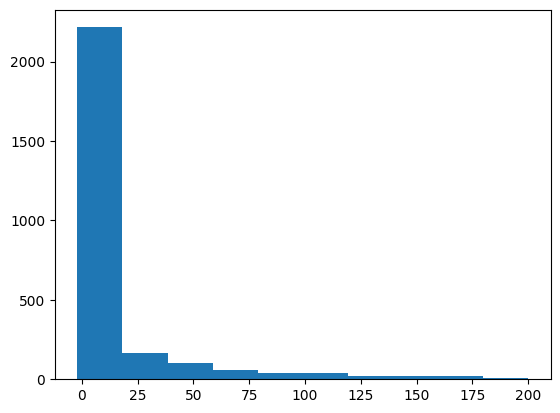

In [124]:
plt.hist(num_intersect_mentions_all, range=(-2, 200))

In [36]:
sft_model_path =  "ckpts/sft_lama_GPT2_commit/checkpoint_10000/hf_model"
sft_generation_categories = np.load(sft_model_path+"/generation_categories.npy")


In [58]:
len(ood_idxs)

3053

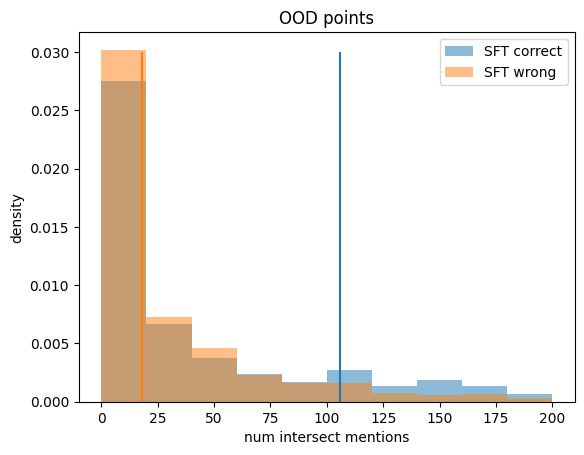

In [72]:
ood_idxs = np.where(sft_generation_categories[:, 0]==3)[0]
correct_idxs = np.where(sft_generation_categories[ood_idxs, 1]==1)[0]
wrong_idxs = np.where(sft_generation_categories[ood_idxs, 1]==0)[0]


plt.hist(((num_intersect_mentions_all))[correct_idxs], alpha=0.5, density=True, range=(0, 200), label = "SFT correct")
plt.hist(((num_intersect_mentions_all))[wrong_idxs], alpha=0.5, density=True, range=(0, 200), label = "SFT wrong")

non_neg_idxs = np.where((num_intersect_mentions_all)[correct_idxs]!=-1)[0]
plt.vlines(np.median((num_intersect_mentions_all)[correct_idxs][non_neg_idxs]), 0, 0.03, color="C0")
non_neg_idxs = np.where((num_intersect_mentions_all)[wrong_idxs]!=-1)[0]
plt.vlines(np.median((num_intersect_mentions_all)[wrong_idxs][non_neg_idxs]), 0, 0.03, color="C1")


plt.title("OOD points")
plt.ylabel("density")
plt.xlabel("num intersect mentions")
plt.legend()




In [75]:
non_neg_idxs = np.where((num_intersect_mentions_all)[correct_idxs]!=-1)[0]
print(np.mean((num_intersect_mentions_all)[correct_idxs][non_neg_idxs]))
non_neg_idxs = np.where((num_intersect_mentions_all)[wrong_idxs]!=-1)[0]
print(np.mean((num_intersect_mentions_all)[wrong_idxs][non_neg_idxs]))


2157.6738703339884
304.4325153374233


In [76]:
non_neg_idxs = np.where((num_intersect_mentions_all)!=-1)[0]
print(np.mean((num_intersect_mentions_all)[non_neg_idxs]))

938.7969065232011


In [78]:
ppo_model_path = "ckpts/ppo_lama_GPT2_3_commit30_hedge25.5_6.5_idk11_cr0.0005/checkpoint_80000/hf_model"
ppo_generation_categories = np.load(ppo_model_path+"/generation_categories.npy")


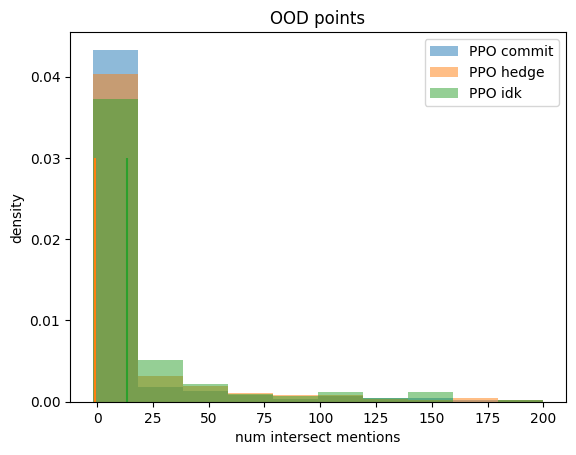

In [119]:
ood_idxs = np.where(ppo_generation_categories[:, 0]==3)[0]

commit_idxs = np.union1d(np.where(ppo_generation_categories[ood_idxs, 1]==1)[0], np.where(ppo_generation_categories[ood_idxs, 2]==1)[0])
hedge_idxs = np.union1d(np.where(ppo_generation_categories[ood_idxs, 5]==1)[0], np.where(ppo_generation_categories[ood_idxs, 6]==1)[0])
dont_know_idxs = np.where(ppo_generation_categories[ood_idxs, 3]==1)[0]


plt.hist(((num_intersect_mentions_all))[commit_idxs], alpha=0.5, density=True, range=(-2, 200), label = "PPO commit")
plt.hist(((num_intersect_mentions_all))[hedge_idxs], alpha=0.5, density=True, range=(-2, 200), label = "PPO hedge")
plt.hist(((num_intersect_mentions_all))[dont_know_idxs], alpha=0.5, density=True, range=(-2, 200), label = "PPO idk")

# non_neg_idxs = np.where((num_intersect_mentions_all)[commit_idxs]!=-1)[0]
plt.vlines(np.median((num_intersect_mentions_all)[commit_idxs]), 0, 0.03, color="C0")
# non_neg_idxs = np.where((num_intersect_mentions_all)[hedge_idxs]!=-1)[0]
plt.vlines(np.median((num_intersect_mentions_all)[hedge_idxs]), 0, 0.03, color="C1")
# non_neg_idxs = np.where((num_intersect_mentions_all)[dont_know_idxs]!=-1)[0]
plt.vlines(np.median((num_intersect_mentions_all)[dont_know_idxs]), 0, 0.03, color="C2")


plt.title("OOD points")
plt.ylabel("density")
plt.xlabel("num intersect mentions")
plt.legend()




In [122]:
non_neg_idxs = np.where((num_intersect_mentions_all)[commit_idxs]!=-1)[0]
print(len(non_neg_idxs)/len(commit_idxs))
print(np.median((num_intersect_mentions_all)[commit_idxs]))
non_neg_idxs = np.where((num_intersect_mentions_all)[hedge_idxs]!=-1)[0]
print(len(non_neg_idxs)/len(hedge_idxs))
print(np.median((num_intersect_mentions_all)[hedge_idxs]))
non_neg_idxs = np.where((num_intersect_mentions_all)[dont_know_idxs]!=-1)[0]
print(len(non_neg_idxs)/len(dont_know_idxs))
print(np.median((num_intersect_mentions_all)[dont_know_idxs]))

0.4071942446043165
-1.0
0.48639455782312924
-1.0
0.684931506849315
13.5


In [103]:
len(np.where(sft_generation_categories[ood_idxs][dont_know_idxs][:, 1]==1)[0])/len(dont_know_idxs)

0.2602739726027397

In [114]:
for template in list(set(ood_dataset["template"])):
    template_idxs = np.where(np.array(ood_dataset["template"]) == template)[0]
    commit_idxs = np.union1d(np.where(ppo_generation_categories[ood_idxs][template_idxs, 1]==1)[0], np.where(ppo_generation_categories[ood_idxs][template_idxs, 2]==1)[0])
    hedge_idxs = np.union1d(np.where(ppo_generation_categories[ood_idxs][template_idxs, 5]==1)[0], np.where(ppo_generation_categories[ood_idxs][template_idxs, 6]==1)[0])
    dont_know_idxs = np.where(ppo_generation_categories[ood_idxs][template_idxs, 3]==1)[0]

    print(template)
    print(np.array([len(commit_idxs), len(hedge_idxs), len(dont_know_idxs)])/len(template_idxs))

[X] is developed by [Y] .
[0.61655405 0.34290541 0.03885135]
[X] was originally aired on [Y] .
[0.0261067  0.8876277  0.08626561]
[X] was written in [Y] .
[0.33751425 0.62029647 0.03876853]
The capital of [X] is [Y] .
[0.01564723 0.75248933 0.22617354]


In [113]:
ood_dataset["template"] == template

False

In [10]:
sft_model_path = "ckpts/sft_lama_GPT2_commit/checkpoint_10000/hf_model"
sft_generation_categories = np.load(sft_model_path+"/generation_categories.npy")

In [12]:

ood_idxs = np.where(sft_generation_categories[:, 0]==3)[0]
noneg_idxs = np.where(num_intersect_mentions_all!=-1)[0]
sft_generation_categories[ood_idxs][noneg_idxs, 1].sum()/len(noneg_idxs)

0.34229993275050435

In [14]:
neg_idxs = np.where(num_intersect_mentions_all==-1)[0]
sft_generation_categories[ood_idxs][neg_idxs, 1].sum()/len(neg_idxs)

0.44763729246487866